In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict
from google.colab import files
import plotly.express as px

## This notebook calculates delays and priorities in a Surveda survey

Surveys have a defined retry window, this code aims to check if the contact attempts match those settings.

The **Channel broker** handles the contact attempts that are sent to the channels, it has 2 queues High (1) and Normal (0) the script check if the contact attempts were sent according to these priorities

In [3]:
#Load data
interaction_url = input('Please paste the URL for the interactions file ')
#results_url = input('Please paste the URL for the results file ')
interaction_df = pd.read_csv(interaction_url)
#results_df = pd.read_csv(results_url)
#interaction_df = pd.read_csv('https://surveda-stg.instedd.org/link/8ba3cf8bfec35e054d0654ea31ff8231')
#results_df = pd.read_csv('https://surveda-stg.instedd.org/link/570eb9e34c41b9d2475b42e5dec6eaf1')


Please paste the URL for the interactions file https://surveda-lk.org/link/146c01abbc7854a12851859bb4710023


In [4]:
# Filter data for IVR (this doesn't work for SMS or MobileWeb yet)
filter_out = ['Enqueueing call', 'Timeout', 'User hangup', 'Call expired, will be retried in next schedule window']

contact_inter_df = interaction_df.loc[(interaction_df['Action Type'] == 'Contact attempt') & (~interaction_df['Action Data'].isin(filter_out))]
contact_inter_df = contact_inter_df.sort_values(['Respondent ID','ID'])

contact_inter_df.to_csv('contact_inter_df.csv', index=False)
files.download('contact_inter_df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import pandas as pd
import datetime as dt

def calculate_retry_time(input_date, delay_hours: int, start_window: int, end_window: int, block_dates: list):
    # Convert input_date to a naive datetime object
    start_date = pd.to_datetime(input_date).tz_localize(None)
    target_datetime = start_date + pd.DateOffset(hours=delay_hours)
    block_dates = [dt.datetime.strptime(date, "%Y-%m-%d").date() for date in block_dates]

    def adjust_to_valid_time(dt_obj):
        if dt_obj.hour < start_window:
            return dt_obj.replace(hour=start_window, minute=0, second=0, microsecond=0)
        elif dt_obj.hour >= end_window:
            return dt_obj.replace(hour=start_window, minute=0, second=0, microsecond=0) + pd.DateOffset(days=1)
        return dt_obj

    # Adjust target_datetime to skip block dates
    while target_datetime.date() in block_dates:
        target_datetime += pd.DateOffset(days=1)

    # Ensure target_datetime is within the valid time window
    valid_target_datetime = adjust_to_valid_time(target_datetime)

    # Recheck block dates if adjustment pushed it to the next day
    while valid_target_datetime.date() in block_dates:
        valid_target_datetime += pd.DateOffset(days=1)
        valid_target_datetime = adjust_to_valid_time(valid_target_datetime)

    return valid_target_datetime

# Example usage
input_date = '2019-08-28 10:01:43 GMT+6'
delay_hours = 26
start_window = 8
end_window = 20
block_dates = ['2019-08-29', '2019-08-30', '2019-08-31']

result = calculate_retry_time(input_date, delay_hours, start_window, end_window, block_dates)
print("Calculated Retry Time:", result)

Calculated Retry Time: 2019-09-01 12:01:43


# Calculate retry time delays

This code crawls the interactions file, seareching for the contact attempt registries and compares its timestamo with the estimated (using calculate_retry_time)

In [6]:
# Differences with timestamp

def retry_accuracy(data, delay_hours: int, start_window: int, end_window: int, retries: int):

    result_list = []

    data['Timestamp'] = pd.to_datetime(data['Timestamp']).dt.tz_localize(None)

    # Group by 'Respondent ID'
    respondents_id = data.groupby('Respondent ID')

    for respondent_id, group in respondents_id:
        occurrences = len(group)

        if occurrences > 1:
            timestamps = pd.to_datetime(group['Timestamp'])
            estimated_retry_time = calculate_retry_time(timestamps.iloc[0], delay_hours, start_window, end_window)
            differences = []
            actual_retry_times = []

            for i in range(1, min(occurrences, retries + 1)):
              diff = (timestamps.iloc[i] - estimated_retry_time)
              differences.append(diff.total_seconds()/3600)
              actual_retry_times.append(timestamps.iloc[i])
              estimated_time = calculate_retry_time(timestamps.iloc[i], delay_hours, start_window, end_window)

            interleaved = [val for pair in zip(differences, actual_retry_times) for val in pair]
            result_list.append([respondent_id] + interleaved)

    columns = ['Respondent ID'] + [f'{label}_{i+2}_attempt' for i in range(retries) for label in ['Lag_in', 'Actual']]
    contact_lag_df = pd.DataFrame(result_list, columns=columns)

    return contact_lag_df

retries = 2
delay_hours = 26
start_window = 8
end_window = 20

contact_lag_df = retry_accuracy(contact_inter_df, delay_hours, start_window, end_window, retries)

# Create csv file to export
contact_lag_df.to_csv('contactLag.csv', index=False)
files.download('contactLag.csv')

<ipython-input-6-ad83d4a59f31>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Timestamp'] = pd.to_datetime(data['Timestamp']).dt.tz_localize(None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

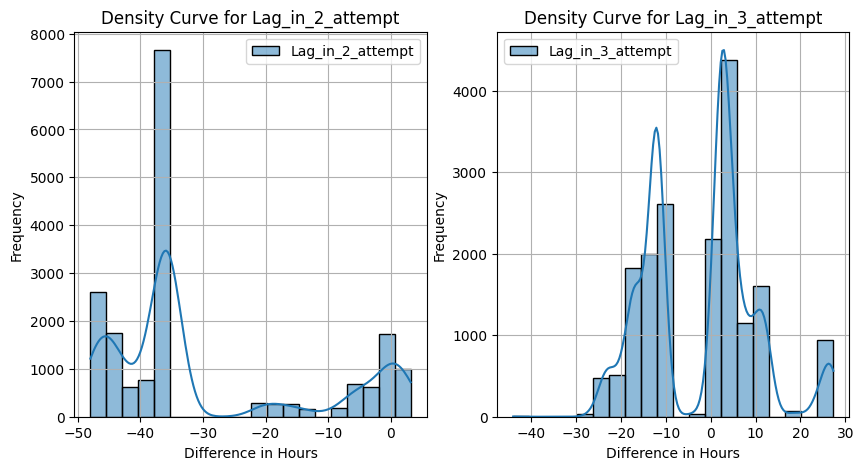

<ipython-input-34-4554f98cbe9f>:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
#Chart time

def create_interactive_bubble_plot(df, attempt_number, time_interval='H', lag_bins=5):
    lag_column = f'Lag_in_{attempt_number}_attempt'
    actual_column = f'Actual_{attempt_number}_attempt'

    df['Timestamp'] = df[actual_column].dt.floor(time_interval)

    df['Lag_Binned'] = pd.cut(df[lag_column], bins=lag_bins)

    grouped_df = df.groupby(['Timestamp', 'Lag_Binned']).size().reset_index(name='Count')

    grouped_df['Lag_Binned'] = grouped_df['Lag_Binned'].apply(lambda x: x.mid)

    fig = px.scatter(grouped_df,
                     x='Timestamp',
                     y='Lag_Binned',
                     size='Count',
                     size_max=40,
                     labels={'Lag_Binned': f'Binned Lag in {attempt_number} Attempt', 'Timestamp': 'Timestamp of Attempt'},
                     title=f'Interactive Bubble Plot of Time (Grouped by {time_interval}) vs Binned Lag for Attempt {attempt_number}')
    fig.show()

# Plot differences
column_names = [f'Lag_in_{i+2}_attempt' for i in range(retries)]
plt.figure(figsize=(5 * retries, 5))

for i, col in enumerate(column_names):
    if col in contact_lag_df.columns:
        plt.subplot(1, retries, i+1)
        sns.histplot(contact_lag_df[col].dropna(), bins=20, kde=True, label=col)
        plt.title(f'Density Curve for {col}')
        plt.xlabel('Difference in Hours')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

plt.show()

# Plot attempts != first over time

contact_lag_df['Day_Hour'] = contact_lag_df['Actual_2_attempt'].dt.floor('H')

fig = px.histogram(contact_lag_df, x='Day_Hour', title='Distribution Frequency of Timestamps per Day and Hour')
fig.update_layout(xaxis_title='Day and Hour', yaxis_title='Frequency')
fig.show()

# Bubble plot
create_interactive_bubble_plot(contact_lag_df, 2, time_interval='H', lag_bins=5)
